In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics
import sklearn.ensemble
import matplotlib.pyplot as plt

In [3]:
log_df = pd.read_csv("data/log_mini.csv")
log_df.rename(columns={"track_id_clean": "track_id"}, inplace=True)
tf_df = pd.read_csv("data/tf_mini.csv")
df = log_df.merge(tf_df, on=["track_id"], how="left")

train, test = sklearn.model_selection.train_test_split(df, test_size=0.2)
x_columns = tf_df.columns[
    ~tf_df.columns.to_series().isin(["duration", "release_year", "track_id", "key", "mode"])]
y_columns = log_df.columns[log_df.columns.str.contains("skip")]
label_map = y_columns.to_numpy()

def process_y(y_df):
    y = np.argmax(y_df[y_columns].to_numpy().astype(int), axis=1)
    return [0 if i==3 else 1 for i in y]


train = train.head(100000)
test = test.head(10000)
train_X = train[x_columns]
train_y = process_y(train[y_columns])
test_X = test[x_columns]
test_y = process_y(test[y_columns])

(0, 'skip_1') (1, 'skip_2') (2, 'skip_3') (3, 'not_skipped')


In [4]:
model = sklearn.ensemble.RandomForestClassifier()
print("Fitting...")
model.fit(train_X, train_y)
print("Fit. Testing...")
preds = model.predict(test_X)
print("Results:")
report = sklearn.metrics.classification_report(test_y, preds, output_dict=True)
report_df = pd.DataFrame(report).rename(columns={"0":"Listen", "1":"Skip"})
print(report_df)
report_df.to_csv("report.csv")

Fitting...
Fit. Testing...
Results:
                Listen         Skip  accuracy     macro avg  weighted avg
precision     0.670701     0.405797    0.6378      0.538249      0.580952
recall        0.888385     0.148760    0.6378      0.518573      0.637800
f1-score      0.764346     0.217711    0.6378      0.491028      0.579146
support    6612.000000  3388.000000    0.6378  10000.000000  10000.000000


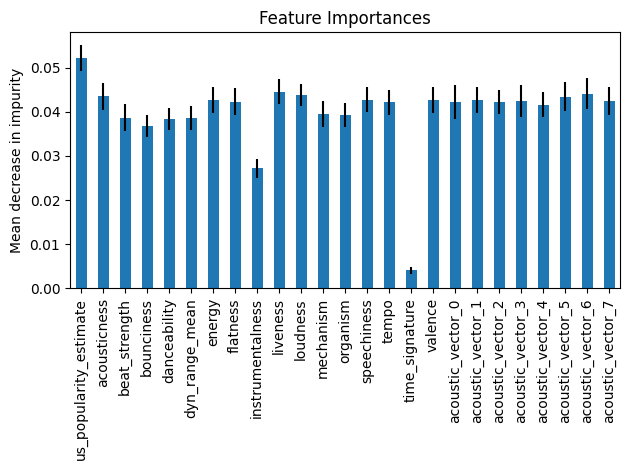

In [5]:
importances = model.feature_importances_
feature_names = x_columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()
